<a href="https://colab.research.google.com/github/dangji1980/JSCEJournalAI/blob/master/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('./drive/My Drive/Colab Notebooks/CNN')

TIMEOUT: ignored

In [ ]:
!nvidia-smi

Wed Sep  2 11:00:27 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:

## reference:https://qiita.com/mainvoidllll/items/db991dc30d3ddced6250
##Edited by Ji Dang 2020.6.29

# some libraries
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Activation, Conv2D, Flatten, Dense,Dropout
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD, Adadelta, Adagrad, Adam, Adamax, RMSprop, Nadam
from PIL import Image
import numpy as np
import glob
import matplotlib.pyplot as plt
import time
import os

In [ ]:
## some constant
foldername="Pics"

In [ ]:
def listdir_nohidden(path): #macでは.ds_dataなど見えないフォルダが存在するので、ここで除去
    filelist=[]
    for f in os.listdir(path):
        if not f.startswith('.'):
            filelist.append(f)
    return filelist

folder = listdir_nohidden(foldername)
image_size = 50
dense_size  = len(folder)
print(folder)

['Cracks', 'Corrosion']


In [ ]:
X = []
Y = []
for index, name in enumerate(folder): #enumerate番号と配列を同時取得
    dir = "./"+foldername+"/" + name
    files = glob.glob(dir + "/*.png")
    for i, file in enumerate(files):
        image = Image.open(file)
        image = image.convert("RGB")
        image = image.resize((image_size, image_size))
        data = np.asarray(image)
        X.append(data)
        Y.append(index)

X = np.array(X)
Y = np.array(Y)
X = X.astype('float32')
X = X / 255.0

Y = np_utils.to_categorical(Y, dense_size)#kerasの小道具箱np_utilsを活用
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10) #sklearnを活用

In [ ]:
def CnnModel():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',input_shape=X_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(dense_size))
    model.add(Activation('softmax'))

    model.summary()
    return model

In [ ]:
model=CnnModel()
#optimizers ="Adadelta"#hyperparameters:SGD, Adagrad, Adam, Adamax, RMSprop, Nadam
optimizers=Adam(lr=0.0001)
#SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
results = {}
epochs = 30     # using 100 or 200?
model.compile(loss='categorical_crossentropy', optimizer=optimizers, metrics=['accuracy'])
results= model.fit(X_train, y_train, validation_split=0.1, epochs=epochs )#<-training

model_json_str = model.to_json()
open('mnist_mlp_model.json', 'w').write(model_json_str)
model.save_weights('mnist_mlp_weights.h5');

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 50, 50, 32)        896       
_________________________________________________________________
activation_7 (Activation)    (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
activation_8 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 64)       

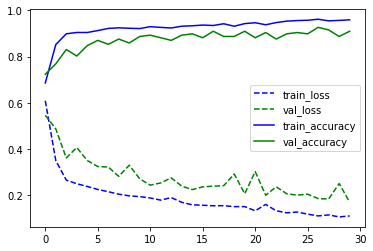

In [ ]:
# visuliazation of training
x = range(epochs)
plt.plot(x,results.history['loss'],color='blue',label='train_loss',linestyle = "dashed")
plt.plot(x,results.history['val_loss'],color='green',label='val_loss',linestyle = "dashed")
plt.plot(x,results.history['accuracy'],color='blue',label='train_accuracy')
plt.plot(x,results.history['val_accuracy'],color='green',label='val_accuracy')
plt.legend()


name = 'val_acc.jpg'
plt.savefig(name, bbox_inches='tight')


In [ ]:
#reference:https://medium.com/@manasnarkar/image-classification-with-convolution-neural-networks-cnn-with-keras-dbd71c05ed2a


test_loss, test_acc = model.evaluate(X_test, y_test)

196/196 [==============================] - 0s 2ms/step


In [ ]:
print(test_acc)

0.918367326259613


Confusion matrix, without normalization
[[90 12]
 [ 4 90]]


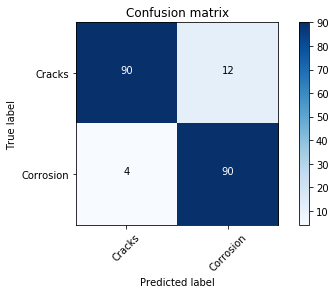

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confutionmatrix.jpg')


pred_y = model.predict(X_test)
pred_y_classes = np.argmax(pred_y,axis = 1) 
tue_y= np.argmax(y_test,axis = 1) 
confusion_mtx = confusion_matrix(tue_y, pred_y_classes) 
plot_confusion_matrix(confusion_mtx, classes = folder) 

# reference:http://kinpatucom821.hatenablog.com/entry/2018/08/30/215419